In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import pickle as pkl
import numpy as np
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.gridspec as gs

pd.options.display.float_format = '{:.5f}'.format

In [2]:
#standardize plots
def custom_plots(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.grid(False)
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

In [3]:
DIR = "/raid5pool/tank/luehring/german_newsguard_tweets/"
DATA_DIR = join(DIR, "discussions/")
FIG_DIR = "/home/luehring/emomis-discussions/emomis-discussion-paper/figures/"

In [4]:
with open(join(DIR, "dtypes_config.pickle"), "rb") as file:
    DTYPES = pkl.load(file)

## COVARIATES PANEL

In [5]:
df_starters = pd.read_csv(join(DATA_DIR,
                      "discussions_starters_aggregates.csv"),
                 usecols=["Rating",
                          "created_at",
                          "anger_log",
                          "fear_log", 
                          "disgust_log", 
                          "sadness_log",
                          "joy_log", 
                          "pride_log", 
                          "hope_log"
                          ],
                          dtype=DTYPES)

len(df_starters)

9906259

In [6]:
# capitalize emotions
df_starters.columns = [col.capitalize() for col in df_starters.columns]

In [7]:
emotions = ["Anger", "Fear",
            "Disgust", "Sadness",
            "Joy", "Pride", "Hope"]

df_starters.columns = [col.replace("_log", "") for col in df_starters.columns]

df_starters["Created_at"] = pd.to_datetime(df_starters["Created_at"])
df_starters["Day"] = df_starters["Created_at"].dt.date
df_starters["Week"] = df_starters["Created_at"].dt.to_period("W")

df_emotions_daily = df_starters.groupby("Day")[emotions].mean()

/tmp/ipykernel_1701499/3676963605.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_starters["Week"] = df_starters["Created_at"].dt.to_period("W")


In [8]:
len(df_starters)

9906259

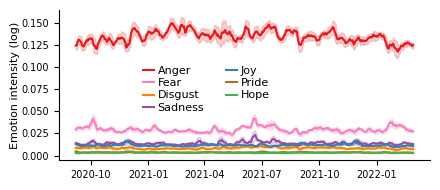

In [9]:
emotion_colormap = {
    "Anger": "#e41a1c",
    "Fear": "#f781bf",
    "Disgust": "#ff7f00",
    "Sadness": "#984ea3",
    "Joy": "#377eb8",
    "Pride": "#a6761d",
    "Hope": "#4daf4a"
}

df_weekly = df_emotions_daily.rolling(window=7).mean()
std_error = df_emotions_daily.rolling(window=7).std() / np.sqrt(7)

ci_multiplier = 1.96 
df_ci_upper = df_weekly + ci_multiplier * std_error
df_ci_lower = df_weekly - ci_multiplier * std_error

fig, ax = plt.subplots(figsize=(4.5, 2))

df_weekly.plot(ax=ax, color=emotion_colormap, legend=False)
for emotion in emotions:
    ax.fill_between(df_weekly.index, df_ci_lower[emotion], df_ci_upper[emotion],
                    color=emotion_colormap[emotion], alpha=0.2)


ax.set_xlabel("", fontsize=8, labelpad=1)
ax.set_ylabel("Emotion intensity (log)", fontsize=8, labelpad=1)
ax.tick_params(axis="both", labelsize=7)


dates = pd.date_range(start=df_weekly.index.min(), 
                      end=df_weekly.index.max(), 
                      freq='3M')  
ax.set_xticks(dates)
ax.set_xticklabels(dates.strftime('%Y-%m'))


ax.legend(loc='lower left', 
          bbox_to_anchor=(0.2, 0.25), 
          ncol=2,
          frameon=False,
          handlelength=1,
          handletextpad=0.3,
          labelspacing=0.2,
          fontsize=8)

custom_plots(ax=ax)

plt.tight_layout()
# plt.savefig("emotions_over_time.png", dpi=300)
# plt.savefig("emotions_over_time.pdf", dpi=300)
plt.show()

In [10]:
df_replies = pd.read_csv(
    join(DATA_DIR, "discussions_replies_aggregates.csv"),
    dtype=DTYPES
)

emotions = ["anger", "fear",
            "disgust", "sadness",
            "joy", "pride", "hope"]

df_replies = df_replies.rename(columns={emo: emo.capitalize() + "*" for emo in emotions})

df_replies.columns

Index(['conversation_id', 'domain', 'author_id', 'created_at',
       'author.followers_count', 'author.following_count',
       'author.tweet_count', 'Rating', 'Score', 'Anger*', 'Fear*', 'Disgust*',
       'Sadness*', 'Joy*', 'Pride*', 'Hope*', 'Orientation', 'word_count',
       'word_count_log', 'author.tweet_count_log',
       'author.followers_count_log', 'author.following_count_log', 'anger_log',
       'fear_log', 'disgust_log', 'sadness_log', 'joy_log', 'pride_log',
       'hope_log', 'anger_avg', 'fear_avg', 'disgust_avg', 'sadness_avg',
       'joy_avg', 'pride_avg', 'hope_avg', 'author.tweet_count_avg',
       'author.tweet_count_avg_log', 'time_diff', 'time_diff_log'],
      dtype='object')

In [11]:
selected_columns = [
    "Anger*", "Fear*", "Disgust*", "Sadness*",
    "Joy*", "Pride*", "Hope*", 
    "word_count_log",
    "time_diff_log",
    "author.tweet_count_log", "author.followers_count_log",
    "author.following_count_log", "anger_log", "fear_log", 
    "disgust_log", "sadness_log", "joy_log", "pride_log", "hope_log"
]
df_covariates = df_replies[selected_columns]

df_covariates.columns = (
    df_covariates.columns
    .str.replace("author.followers_count_log", "Followers", regex=False) 
    .str.replace("author.following_count_log", "Following", regex=False)  
    .str.replace("author.tweet_count_log", "Tweet count", regex=False) 
    .str.replace("word_count_log", "Word count", regex=False)
    .str.capitalize() 
    .str.replace("Time_diff_log", "DTS", regex=False)
    .str.replace("_log", "")
)

df_covariates.columns

Index(['Anger*', 'Fear*', 'Disgust*', 'Sadness*', 'Joy*', 'Pride*', 'Hope*',
       'Word count', 'DTS', 'Tweet count', 'Followers', 'Following', 'Anger',
       'Fear', 'Disgust', 'Sadness', 'Joy', 'Pride', 'Hope'],
      dtype='object')

In [12]:
y_vars = ["Anger", "Fear", 
          "Disgust", "Sadness",
          "Joy", "Pride", "Hope",
          "Word count",
          "Tweet count", 
          "DTS",
          "Followers",
          "Following"]

x_vars = ["Anger*", "Fear*", "Disgust*", "Sadness*",
          "Joy*", "Pride*", "Hope*"]

corr = df_covariates[y_vars + x_vars].corr()

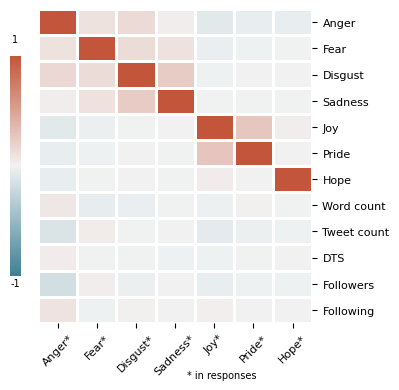

In [13]:
fig, ax = plt.subplots(figsize=(4.5, 4))

cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(
    corr.loc[y_vars, x_vars],
    cmap=cmap, vmin=-1, vmax=1, center=0,
    square=False, linewidths=1,
    cbar=False, 
    xticklabels=x_vars, yticklabels=y_vars,
    ax=ax
)

ax.tick_params(axis='x', labelrotation=45, 
                labelsize=8)

ax.yaxis.tick_right() 
ax.yaxis.set_label_position("right")  
ax.tick_params(axis="y", 
                  which="both", 
                  labelsize=8, 
                  pad=4, 
                  labelrotation=0)

ax.text(0.67, -0.15, "* in responses",
        transform=ax.transAxes, 
        ha='center', 
        va='top', 
        fontsize=7)
cbar = ax.figure.colorbar(ax.collections[0], 
                             ax=ax, location='left', 
                             pad=0.05, shrink=0.7)
cbar.outline.set_visible(False)
cbar.set_ticks([])

cbar.ax.text(0.5, 1.1, '1', transform=cbar.ax.transAxes, 
             ha='center', va='top', fontsize=7)
cbar.ax.text(0.5, -0.01, '-1', transform=cbar.ax.transAxes, 
             ha='center', va='top', fontsize=7)
                        

plt.tight_layout()
# plt.savefig("covariates_correlation.png")
plt.show()

In [14]:
barplot_map = ["#1b9e77", "#7570b3"]

df_rating = df_starters\
    .groupby(["Week", "Rating"])\
        .size().unstack().fillna(0)

df_rating = df_rating.div(df_rating.sum(axis=1), axis=0)

# aggregate the average across time and the std
df_rating_agg = df_rating.agg(["mean", "std"]).T.round(3)

# multiply by 100 to get percentage
df_rating_agg = df_rating_agg * 100
df_rating_agg.index = ["Trustworthy", "Untrustworthy"]
df_rating_agg

,mean,std
Trustworthy,94.00000,0.60000
Untrustworthy,6.00000,0.60000


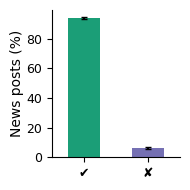

In [15]:
fig, ax = plt.subplots(figsize=(2, 2))
ax = df_rating_agg.plot(kind="bar", 
                   y="mean", yerr="std", 
                   color=barplot_map, 
                   capsize=2,
                   ax=ax)

# no legend
ax.legend().set_visible(False)
ax.set_xticklabels([u"\u2714",u"\u2718"], 
                        rotation=0,
                        fontsize=10)
ax.set_ylabel("News posts (%)", 
                   fontsize=10,
                   labelpad=1.5)
ax.tick_params(axis="both", labelsize=9)
custom_plots(ax=ax)
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_label_position('left')
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
# custom_plots(ax=ax)
plt.tight_layout()
# plt.savefig( "trustworthiness.png")
# plt.savefig( "trustworthiness.pdf")
plt.show()

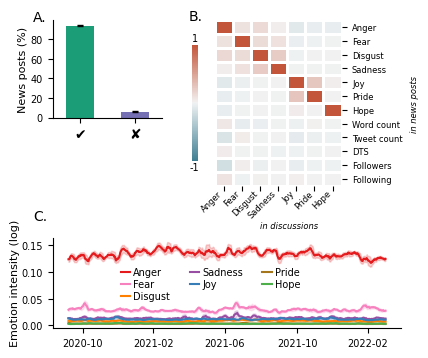

In [16]:
emotions = ["Anger", "Fear",
            "Disgust", "Sadness",
            "Joy", "Pride", "Hope"]

fig = plt.figure(figsize=(4.5, 4))
grid = fig.add_gridspec(6, 6, 
                        height_ratios=[0.5, 
                                       0.2, 
                                       0.1, 0.22, 
                                       0.22, 0.22], 
                        width_ratios=[1, 1, 1, 1, 1,1], 
                        wspace=0.2, 
                        hspace=0.1)

# Plot 1: Barplot for the ratings
ax_bar = fig.add_subplot(grid[0, :2])

df_rating_agg.plot(kind="bar", 
                   y="mean", yerr="std", 
                   color=barplot_map, 
                   capsize=2,
                   ax=ax_bar)

# no legend
ax_bar.legend().set_visible(False)
ax_bar.set_xticklabels([u"\u2714", u"\u2718"], 
                        rotation=0,
                        fontsize=10)

ax_bar.set_ylabel("News posts (%)", 
                   fontsize=8,
                   labelpad=1.5)
ax_bar.tick_params(axis="y", labelsize=7)
custom_plots(ax=ax)
ax_bar.yaxis.set_ticks_position('left')
ax_bar.yaxis.set_label_position('left')
ax_bar.spines['left'].set_visible(True)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)

ax_bar.set_title("A.", loc="left",
                    x=-0.18, y=0.9,
                    fontsize=10)

# Plot 2: Heatmap in the last subplot
ax_hm = fig.add_subplot(grid[:3, 2:5])  
# ax_hm = fig.add_subplot(grid[:4, 1:5])

cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(
    corr.loc[y_vars, x_vars],
    cmap=cmap, vmin=-1, vmax=1, center=0,
    square=False, linewidths=0.75,
    cbar=False, 
    xticklabels=x_vars, yticklabels=y_vars,
    ax=ax_hm
)

ax_hm.tick_params(axis='x', labelsize=6, labelrotation=60, pad=-0.1)
ax_hm.tick_params(axis='y', labelsize=7)
ax_hm.text(11, 8, "in news posts", 
           fontstyle='italic',
           rotation=90,
           horizontalalignment='center', 
           fontsize=6)
ax_hm.set_title("B.", loc="left", fontsize=10,
                x=-0.2, y=0.95)
ax_hm.yaxis.tick_right() 
ax_hm.yaxis.set_label_position("right")  
ax_hm.tick_params(axis="y", 
                  which="both", 
                  labelsize=6, 
                  pad=4, 
                  labelrotation=0)

ax_hm.text(1.81, 0.67, 
        "in discussions",
        fontstyle='italic',
        transform=ax.transAxes, 
        ha='center', 
        va='top', 
        fontsize=6)

cbar = ax_hm.figure.colorbar(ax_hm.collections[0], 
                             ax=ax_hm, location='left', 
                             pad=0.1, shrink=0.7)
cbar.outline.set_visible(False)
cbar.set_ticks([])

cbar.ax.text(0.5, 1.1, '1', transform=cbar.ax.transAxes, 
             ha='center', va='top', fontsize=7)
cbar.ax.text(0.5, -0.01, '-1', transform=cbar.ax.transAxes, 
             ha='center', va='top', fontsize=7)

ax_hm.set_xticklabels(emotions, 
                      rotation=45, 
                      ha='right',
                      position=(0, 0.01),
                      fontsize=6)

# Plot 3: Weekly emotions with confidence intervals
ax_emo = fig.add_subplot(grid[4:, 0:]) 
df_weekly = df_emotions_daily.rolling(window=7).mean()
std_error = df_emotions_daily.rolling(window=7).std() / np.sqrt(7)
ci_multiplier = 1.96
df_ci_upper = df_weekly + ci_multiplier * std_error
df_ci_lower = df_weekly - ci_multiplier * std_error

df_weekly.plot(ax=ax_emo, color=emotion_colormap, legend=False)
for emotion in emotions:
    ax_emo.fill_between(df_weekly.index, df_ci_lower[emotion], df_ci_upper[emotion],
                        color=emotion_colormap[emotion], alpha=0.2)

ax_emo.set_xlabel("", fontsize=8, labelpad=1)
ax_emo.set_ylabel("Emotion intensity (log)", fontsize=8, labelpad=1)
ax_emo.tick_params(axis="both", labelsize=7)
dates = pd.date_range(start=df_weekly.index.min(), 
                      end=df_weekly.index.max(), 
                      freq='4M')
ax_emo.set_xticks(dates)
ax_emo.set_xticklabels(dates.strftime('%Y-%m'))
ax_emo.legend(loc='upper left', 
              bbox_to_anchor=(0.17, 0.77), 
              ncol=3, frameon=False,
              handlelength=1, 
              handletextpad=0.3, 
              labelspacing=0.2, 
              fontsize=7)
ax_emo.set_title("C.", loc="left", 
                 x=-0.055, y=1.1,
                 fontsize=10)
custom_plots(ax=ax_emo)


# plt.savefig(join("covariates_panel.pdf"), dpi=300, 
#             # pad_inches=0.5,
#             bbox_inches='tight')

# plt.savefig(join(FIG_DIR, "covariates_panel.pdf"), dpi=300, 
#             # pad_inches=0.5,
#             bbox_inches='tight')
plt.show()

## MAIN EFFECTS FIGURE

In [17]:
coeffs_dtypes = {
    "Coefficient": float, 
    "CI_Lower": float, 
    "CI_Upper": float
}

def process_coeffs(path, dtypes):
    df = pd.read_csv(path, dtype=dtypes)
    df["DV"] = df["DV"].str.replace("_avg", "").str.replace("_first", "")
    return df

replies_coeffs = process_coeffs("./discussions/replies/replies_coeffs.csv", coeffs_dtypes)
replies_coeffs_boot = process_coeffs("./discussions/replies/replies_coeffs_boot.csv", coeffs_dtypes)
first_coeffs = process_coeffs("./discussions/replies/replies_first_coeffs.csv", coeffs_dtypes)
first_coeffs_boot = process_coeffs("./discussions/replies/replies_first_coeffs_boot.csv", coeffs_dtypes)

same_coeffs = pd.read_csv("./discussions/same_responders/same_coeffs_emotions.csv",
                          dtype=coeffs_dtypes)

replies_coeffs

,DV,Coefficient,SE,CI_Lower,CI_Upper,P-Value,R-Squared,Cond_Mean
0,Anger,0.03132,0.00243,0.02655,0.03608,0.00000,0.01552,0.36862
1,Disgust,0.00359,0.00058,0.00246,0.00472,0.00000,0.00565,0.01718
2,Fear,0.00185,0.00052,0.00082,0.00288,0.00042,0.00575,0.01503
3,Sadness,0.00092,0.00058,-0.00021,0.00206,0.10908,0.01328,0.01763
4,Joy,-0.00361,0.00087,-0.00531,-0.00191,0.00003,0.00808,0.03202
5,Pride,-0.00032,0.00026,-0.00083,0.00019,0.22073,0.00133,0.00527
6,Hope,-0.00008,0.00037,-0.00080,0.00063,0.81903,0.00157,0.00749


In [18]:
# take lower and upper percentile of the bootstrapped coefficients
def take_percentile(df):
    df_perc = df.groupby("DV")["Coefficient_boot"].quantile([0.025, 0.975]).unstack()
    df_perc.columns = ["CI_Lower_boot", "CI_Upper_boot"]
    df_perc = df_perc.reset_index()
    df['DV'] = df['DV'].astype(str)
    df_perc.columns = ["Emotion", "CI_Lower_boot", "CI_Upper_boot"]
    return df_perc

replies_boot_ci = take_percentile(replies_coeffs_boot)
first_boot_ci = take_percentile(first_coeffs_boot)
replies_boot_ci

,Emotion,CI_Lower_boot,CI_Upper_boot
0,Anger,0.02653,0.03613
1,Disgust,0.00246,0.00473
2,Fear,0.00082,0.00286
3,Hope,-0.00082,0.00065
4,Joy,-0.00529,-0.00193
5,Pride,-0.00083,0.00020
6,Sadness,-0.00021,0.00203


In [19]:
# standardize the column and dv names 
def standardize_names(df):
    df["DV"] = df["DV"].str.replace("_first", "").str.replace("_avg", "")
    df["DV"] = df["DV"].str.capitalize()
    df['DV'] = df['DV'].astype(str)
    df.rename(columns={"DV": "Emotion"}, inplace=True)
    return df

replies_coeffs = standardize_names(replies_coeffs)
first_coeffs = standardize_names(first_coeffs)

In [20]:
same_coeffs = same_coeffs.rename(
    columns={"Estimate": "Coefficient"})
same_coeffs

,Emotion,Coefficient,p,R2,Change,CI_Lower_boot,CI_Upper_boot
0,Anger,0.00881,0.46131,0.00011,2.43000,-0.01482,0.03225
1,Disgust,0.00730,0.01172,0.00123,44.25000,0.00161,0.01302
2,Fear,0.00731,0.00436,0.00158,59.19000,0.00238,0.01249
3,Sadness,-0.00279,0.34870,0.00017,-13.31000,-0.00869,0.00302
4,Joy,0.00154,0.72898,0.00002,4.73000,-0.00725,0.01020
5,Hope,-0.00135,0.42294,0.00012,-17.66000,-0.00472,0.00192
6,Pride,-0.00302,0.04463,0.00078,-39.45000,-0.00606,-0.00013


In [21]:
# add bootstrapped CI to the dataframes
replies_coeffs = replies_coeffs.merge(replies_boot_ci, on="Emotion")
first_coeffs = first_coeffs.merge(first_boot_ci, on="Emotion")

In [22]:
# sort according to Coefficient
replies_coeffs = replies_coeffs.sort_values("Coefficient")
first_coeffs = first_coeffs.sort_values("Coefficient")
same_coeffs = same_coeffs.sort_values("Coefficient")

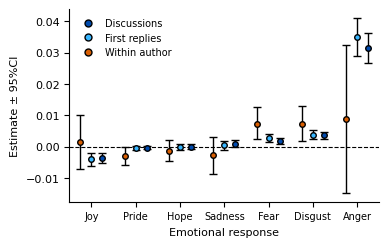

In [23]:
df_colormap = {
    "Discussions": "#004aad",
    "First replies": "#38b6ff",
    "Same author replies": "#d95f02"}

fig1, ax1 = plt.subplots(figsize=(4, 2.5))  

emotion_categories = replies_coeffs["Emotion"].unique()
emotion_positions = {emotion: i for i, emotion in enumerate(emotion_categories)}
replies_coeffs["Emotion_Pos"] = replies_coeffs["Emotion"].map(emotion_positions)
first_coeffs["Emotion_Pos"] = first_coeffs["Emotion"].map(emotion_positions)
same_coeffs["Emotion_Pos"] = same_coeffs["Emotion"].map(emotion_positions)

ax1.errorbar(replies_coeffs["Emotion_Pos"] + 0.25, 
             replies_coeffs["Coefficient"],
             yerr=[replies_coeffs["Coefficient"] - replies_coeffs["CI_Lower_boot"],
                   replies_coeffs["CI_Upper_boot"] - replies_coeffs["Coefficient"]],
             fmt="o", color=df_colormap["Discussions"],
             ecolor="black",
             markeredgecolor="black",
             markersize=4, elinewidth=1, capsize=3,
             label="Discussions")

ax1.errorbar(first_coeffs["Emotion_Pos"], 
             first_coeffs["Coefficient"],
             yerr=[first_coeffs["Coefficient"] - first_coeffs["CI_Lower_boot"],
                   first_coeffs["CI_Upper_boot"] - first_coeffs["Coefficient"]],
             fmt="o", color=df_colormap["First replies"], 
             ecolor="black", 
             markeredgecolor="black",
             markersize=4, elinewidth=1, capsize=3,
             label="First replies")

ax1.errorbar(same_coeffs["Emotion_Pos"] - 0.25,  
             same_coeffs["Coefficient"],
             yerr=[same_coeffs["Coefficient"] - same_coeffs["CI_Lower_boot"],
                   same_coeffs["CI_Upper_boot"] - same_coeffs["Coefficient"]],
             fmt="o", color=df_colormap["Same author replies"], 
             ecolor="black", 
             markeredgecolor="black",
             markersize=4, elinewidth=1, capsize=3,
             label="Same author replies")

ax1.axhline(0, color="black", linestyle="--", linewidth=0.8)
ax1.set_ylabel("Estimate ± 95%CI", fontsize=8)  
ax1.set_xlabel("Emotional response", fontsize=8)
ax1.set_xticks(list(emotion_positions.values()))
ax1.set_xticklabels(emotion_categories, fontsize=7)
ax1.tick_params(axis="y", labelsize=8)
ax1.set_xlim(-0.5, len(emotion_categories) - 0.5)
custom_plots(ax=ax1) 

# Custom legend
discussions_marker = mlines.Line2D([], [], color=df_colormap["Discussions"], marker='o', markersize=5, markeredgecolor="black", linestyle="None", label="Discussions")
first_replies_marker = mlines.Line2D([], [], color=df_colormap["First replies"], marker='o', markersize=5, markeredgecolor="black", linestyle="None", label="First replies")
same_author_marker = mlines.Line2D([], [], color=df_colormap["Same author replies"], marker='o', markersize=5, markeredgecolor="black", linestyle="None", label="Within author")

ax1.legend(handles=[discussions_marker, first_replies_marker, same_author_marker], 
           loc="upper left", fontsize=7, frameon=False)


# plt.savefig("emotion_effects.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [24]:
def import_counts(dv):
    counts = pd.read_csv(f"./engagement/negative_binomial/{dv}_count_zinb_predicted.csv") 
    counts["DV"] = dv
    counts["DV"] = counts["DV"].str.capitalize()
    # exponentiate Est.1
    counts["Est.1"] = np.exp(counts["Est.1"])
    counts["pLL"] = np.exp(counts["pLL"])
    counts["pUL"] = np.exp(counts["pUL"])
    return counts

like_predictions = import_counts("like")
retweet_predictions = import_counts("retweet")
reply_predictions = import_counts("reply")
quote_predictions = import_counts("quote")

predictions = pd.concat([like_predictions, retweet_predictions, reply_predictions, quote_predictions])

# exponentiate
predictions["predicted_counts"] = np.exp(predictions["predicted_counts"])
predictions

,Rating,Bias,anger_log,fear_log,disgust_log,sadness_log,joy_log,pride_log,hope_log,word_count_log,author.followers_count_log,author.following_count_log,author.tweet_count_log,predicted_counts,Est.1,pLL,pUL,DV
0,0,0,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,3.82004,3.81578,3.60812,4.06095,Like
1,1,0,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,2.66373,2.65773,2.54760,2.77477,Like
2,0,1,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,5.56241,5.55940,5.35686,5.89266,Like
3,1,1,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,3.67004,3.67043,3.54975,3.80158,Like
0,0,0,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,1.52204,1.52207,1.49836,1.54876,Retweet
1,1,0,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,1.77740,1.77745,1.74130,1.81802,Retweet
2,0,1,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,1.85025,1.85025,1.82172,1.87637,Retweet
3,1,1,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,2.32822,2.32820,2.28097,2.38154,Retweet
0,0,0,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,1.29863,1.29864,1.28619,1.31174,Reply
1,1,0,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,1.23438,1.23438,1.22577,1.24391,Reply


In [25]:
means = predictions.groupby(["DV", "Rating"])[["predicted_counts"]].agg(
    Mean=("predicted_counts", "mean"),
    Count=("predicted_counts", "count")
).reset_index()

pUL = predictions.groupby(["DV", "Rating"])["pUL"].quantile(0.975).reset_index()
pLL = predictions.groupby(["DV", "Rating"])["pLL"].quantile(0.025).reset_index()

grouped = means.merge(pUL, on=["DV", "Rating"]).merge(pLL, on=["DV", "Rating"])
grouped

,DV,Rating,Mean,Count,pUL,pLL
0,Like,0,4.69122,2,5.84687,3.65183
1,Like,1,3.16688,2,3.77591,2.57265
2,Quote,0,1.08266,2,1.09687,1.06727
3,Quote,1,1.08378,2,1.09993,1.06569
4,Reply,0,1.34329,2,1.39402,1.28855
5,Reply,1,1.26431,2,1.30036,1.22733
6,Retweet,0,1.68614,2,1.86818,1.50644
7,Retweet,1,2.05281,2,2.36745,1.75479


In [26]:
# recode 0 into Trustworthy and 1 into Untrustworthy
grouped.Rating = grouped.Rating.replace({0: "Trustworthy", 1: "Untrustworthy"})
grouped

,DV,Rating,Mean,Count,pUL,pLL
0,Like,Trustworthy,4.69122,2,5.84687,3.65183
1,Like,Untrustworthy,3.16688,2,3.77591,2.57265
2,Quote,Trustworthy,1.08266,2,1.09687,1.06727
3,Quote,Untrustworthy,1.08378,2,1.09993,1.06569
4,Reply,Trustworthy,1.34329,2,1.39402,1.28855
5,Reply,Untrustworthy,1.26431,2,1.30036,1.22733
6,Retweet,Trustworthy,1.68614,2,1.86818,1.50644
7,Retweet,Untrustworthy,2.05281,2,2.36745,1.75479


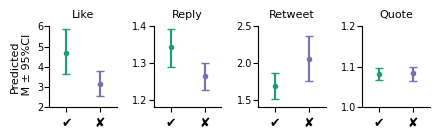

In [27]:
fig = plt.figure(figsize=(4.5, 1.5))
gs = fig.add_gridspec(1, 4)

rating_cmap = {
    "Trustworthy": "#1b9e77",
    "Untrustworthy": "#7570b3"}


for i, dv in enumerate(["Like", "Reply", "Retweet", "Quote"]):
    ax = fig.add_subplot(gs[0, i])  
    dv_data = grouped[grouped["DV"] == dv]

    for rating in dv_data["Rating"].unique():
        rating_data = dv_data[dv_data["Rating"] == rating]
        ax.errorbar(
            x=rating, 
            y=rating_data["Mean"].values[0], 
            yerr=[rating_data["Mean"] - rating_data["pLL"], 
                  rating_data["pUL"] - rating_data["Mean"]],
            fmt="o-", 
            markersize=3, 
            capsize=3, 
            color=rating_cmap[rating],
            label=dv if rating == 0 else None
        )
    
    ax.set_xlabel("", fontsize=8)
    ax.set_ylabel("Predicted\n M ± 95%CI", fontsize=8) if i == 0 else ax.set_ylabel("")
    ax.tick_params(axis="both", which="major", labelsize=7)
    ax.set_xticks([0, 1])
    ax.set_xticklabels([u"\u2714", u"\u2718"], fontsize=9)
    ax.set_xlim(-0.5, 1.5)
    ax.yaxis.set_tick_params(pad=0.8)


    if dv == "Like":
        ax.set_ylim(ymin=2, ymax=6)
        ax.set_yticks([2, 3, 4, 5, 6])  
    elif dv == "Retweet":
        ax.set_ylim(ymin=1.4, ymax=2.5)
        ax.set_yticks([1.5, 2.0, 2.5])  
    elif dv == "Reply":
        ax.set_ylim(ymin=1.18, ymax=1.4)
        ax.set_yticks([1.2, 1.3, 1.4]) 
    else:
        ax.set_ylim(ymin=1, ymax=1.2)
        ax.set_yticks([1, 1.1, 1.2]) 

    ax.set_title(dv, fontsize=8)
    custom_plots(ax=ax)

plt.tight_layout()
# plt.savefig("engagement_effects.png", dpi=300)

plt.show()

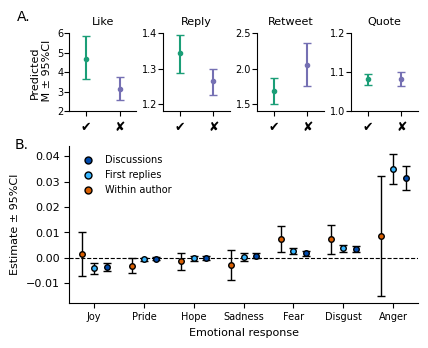

In [ ]:
fig = plt.figure(figsize=(4.5, 3.5))
gs = fig.add_gridspec(2, 4, 
              figure=fig,
              height_ratios=[0.5, 1],
              width_ratios=[1, 1, 1, 1],
              wspace=0.4, 
              hspace=0.3)

# PLOT A: Spanning all 4 columns in the first row
# -----------------------------------------------
ax1 = fig.add_subplot(gs[1, :])  # First row spans all columns

emotion_categories = replies_coeffs["Emotion"].unique()
emotion_positions = {emotion: i for i, emotion in enumerate(emotion_categories)}
replies_coeffs["Emotion_Pos"] = replies_coeffs["Emotion"].map(emotion_positions)
first_coeffs["Emotion_Pos"] = first_coeffs["Emotion"].map(emotion_positions)
same_coeffs["Emotion_Pos"] = same_coeffs["Emotion"].map(emotion_positions)

ax1.errorbar(replies_coeffs["Emotion_Pos"] + 0.25, 
             replies_coeffs["Coefficient"],
             yerr=[replies_coeffs["Coefficient"] - replies_coeffs["CI_Lower_boot"],
                   replies_coeffs["CI_Upper_boot"] - replies_coeffs["Coefficient"]],
             fmt="o", color=df_colormap["Discussions"],
             ecolor="black",
             markeredgecolor="black",
             markersize=4, elinewidth=1, capsize=3,
             label="Discussions")

ax1.errorbar(first_coeffs["Emotion_Pos"], 
             first_coeffs["Coefficient"],
             yerr=[first_coeffs["Coefficient"] - first_coeffs["CI_Lower_boot"],
                   first_coeffs["CI_Upper_boot"] - first_coeffs["Coefficient"]],
             fmt="o", color=df_colormap["First replies"], 
             ecolor="black", 
             markeredgecolor="black",
             markersize=4, elinewidth=1, capsize=3,
             label="First replies")

ax1.errorbar(same_coeffs["Emotion_Pos"] - 0.25,  
             same_coeffs["Coefficient"],
             yerr=[same_coeffs["Coefficient"] - same_coeffs["CI_Lower_boot"],
                   same_coeffs["CI_Upper_boot"] - same_coeffs["Coefficient"]],
             fmt="o", color=df_colormap["Same author replies"], 
             ecolor="black", 
             markeredgecolor="black",
             markersize=4, elinewidth=1, capsize=3,
             label="Same author replies")

ax1.axhline(0, color="black", linestyle="--", linewidth=0.8)
ax1.set_ylabel("Estimate ± 95%CI", fontsize=8)  
ax1.set_xlabel("Emotional response", fontsize=8)
ax1.set_xticks(list(emotion_positions.values()))
ax1.set_xticklabels(emotion_categories, fontsize=7)
ax1.tick_params(axis="y", labelsize=8)
ax1.set_xlim(-0.5, len(emotion_categories) - 0.5)
custom_plots(ax=ax1) 

discussions_marker = mlines.Line2D([], [], 
                                   color=df_colormap["Discussions"], 
                                   marker='o', markersize=5, 
                                   markeredgecolor="black", 
                                   linestyle="None", 
                                   label="Discussions")
first_replies_marker = mlines.Line2D([], [], 
                                     color=df_colormap["First replies"], 
                                     marker='o', markersize=5, 
                                     markeredgecolor="black", 
                                     linestyle="None", 
                                     label="First replies")

same_author_marker = mlines.Line2D([], [], 
                                   color=df_colormap["Same author replies"], 
                                   marker='o', markersize=5, 
                                   markeredgecolor="black", 
                                   linestyle="None", 
                                   label="Within author")

ax1.legend(handles=[discussions_marker, 
                    first_replies_marker, 
                    same_author_marker
                    ], 
           loc="upper left", fontsize=7, frameon=False)


# PLOT B
# ------------------------------------
# order the DVs manually to have a set order of the plots
# colors for rating


for i, dv in enumerate(["Like", "Reply", "Retweet", "Quote"]):
    ax = fig.add_subplot(gs[0, i])  
    dv_data = grouped[grouped["DV"] == dv]

    for rating in dv_data["Rating"].unique():
        rating_data = dv_data[dv_data["Rating"] == rating]
        ax.errorbar(
            x=rating, 
            y=rating_data["Mean"].values[0], 
            yerr=[rating_data["Mean"] - rating_data["pLL"], 
                  rating_data["pUL"] - rating_data["Mean"]],
            fmt="o-", 
            markersize=3, 
            capsize=3, 
            color=rating_cmap[rating],
            label=dv if rating == 0 else None
        )
    
    ax.set_xlabel("", fontsize=8)
    ax.set_ylabel("Predicted\n M ± 95%CI", 
                  fontsize=8) if i == 0 else ax.set_ylabel("")
    ax.tick_params(axis="both", which="major", labelsize=7)
    ax.set_xticks([0, 1])
    ax.set_xticklabels([u"\u2714", u"\u2718"], fontsize=9)
    ax.set_xlim(-0.5, 1.5)
    ax.yaxis.set_tick_params(pad=0.8)


    if dv == "Like":
        ax.set_ylim(ymin=2, ymax=6)
        ax.set_yticks([2, 3, 4, 5, 6])  
    elif dv == "Retweet":
        ax.set_ylim(ymin=1.4, ymax=2.5)
        ax.set_yticks([1.5, 2.0, 2.5])  
    elif dv == "Reply":
        ax.set_ylim(ymin=1.18, ymax=1.4)
        ax.set_yticks([1.2, 1.3, 1.4]) 
    else:
        ax.set_ylim(ymin=1, ymax=1.2)
        ax.set_yticks([1, 1.1, 1.2]) 

    ax.set_title(dv, fontsize=8)
    custom_plots(ax=ax)


# add titles
ax1.set_title("A.", loc="left", 
              fontsize=10, x=-0.15, y=1.75)
fig.text(0.02, 0.55, "B.", 
         ha="center", 
         fontsize=10)

# plt.savefig(
#     join(FIG_DIR, "causal_effects.pdf"), 
#         dpi=300,
#         bbox_inches='tight')

# plt.savefig("causal_effects.pdf", 
#         dpi=300,
#         bbox_inches='tight')

plt.show()